In [1]:
import numpy as np  # package for arrays
import matplotlib.pyplot as plt  # package for plotting
import time  # for timing
# display plots inside of notebook
%matplotlib inline

We have an $M$ by $N$ lattice of spins. Let $\sigma_i \in \{-1, 1\}$ be the spin of lattice site $i$. The energy of the system is:

$\sum_{(i,j)} ' -J \sigma_i \sigma_j - \sum_j h \sigma _j$,
    
where the prime denotes a sum over nearest neighbors on the $M$ by $N$ lattice.

We implement periodic boundary conditions to mimic a system of infinite extent.

The following class, `IsingModel`, is a data structure to store attributes of an Ising Model and provide abstractions to manipulate the lattice for simulations.

For example, to construct an instance of an `IsingModel` class as a 20 by 10 lattice with $J=1.0$ and $h=0$:

    model = IsingModel(20, 10, 1.0, 0.0)
    model.print_attributes()

The lattice state is stored in an $M$ by $N$ numpy array, `lattice_state`; each entry is either -1 and 1. Each site of the lattice is initialized as -1 or 1 with equal probability in the initial construction of an instance. Retreive the lattice state by:

    model.lattice_state
    
Plot the lattice state by:

    model.plot_lattice()
    
We can conveniently manipulate the lattice for simulations. For example, to flip the spin in row 2 and column 3 and calculate the energy of this spin:

    model.flip_spin(2, 3)
    model.calculate_energy_of_spin(2, 3)
    

In [2]:
class IsingModel:
    """
    Store attributes of an Ising lattice model
    Provide abstractions to conveniently manipulate lattice for simulations
    """
    def __init__(self, M, N, J, h):
        """
        Initialization.
        
        parameters:
            lattice is M by N sites
            J: interaction between neighbors (units: kT)
            h: background field (units: kT)
        """
        # store parameters for convenience:
        #   energetic parameters
        self.J = J
        self.h = h
        
        #   size of lattice
        self.M = M
        self.N = N
        
        # store lattice state with M by N array of -1 or 1
        # initialize each site as -1 or 1 with equal probability
        lattice_state = np.random.randint(-1, high=1, size=(M, N))
        lattice_state[lattice_state == 0] = 1
        self.lattice_state = lattice_state
    
    def print_params(self):
        """
        Print lattice attributes
        """
        print("\t%d by %d lattice" % (self.M, self.N))
        print("\tJ = %f   (+ve means preferable )" % self.J)
        print("\th = %f" % self.h)
    
    def critical_kT(self):
        """
        Calculate critical temperature of this lattice model. Depends on J.
        """
        return 2.0 * self.J / (np.log(1.0 + np.sqrt(2.0)))
    
    def flip_spin(self, i, j):
        """
        Flip spin (i, j)
        i.e. -1 ---> 1
              1 ---> -1
        """
        self.lattice_state[i, j] = - self.lattice_state[i, j]
    
    def calculate_energy_of_spin(self, i, j):
        """
        Calculate energy of spin (i, j)
        
        Periodic boundary conditions implemented
        """
        spin_here = self.lattice_state[i, j]  # value of spin here
        
        # value of spin above, below, left, and right of spin (i, j)
        # for each, if on boundary, we wrap around to the other side
        # of the lattice for periodic boundary conditions
        if j == 0:
            spin_above = self.lattice_state[i, self.N - 1]
        else:
            spin_above = self.lattice_state[i, j - 1]
        
        if j == self.N - 1:
            spin_below = self.lattice_state[i, 0]
        else:
            spin_below = self.lattice_state[i, j + 1]
            
        if i == self.M - 1:
            spin_right = self.lattice_state[0, j]
        else:
            spin_right = self.lattice_state[i + 1, j]
        
        if i == 0:
            spin_left = self.lattice_state[self.M - 1, j]
        else:
            spin_left = self.lattice_state[i - 1, j]
        
        return - self.h * spin_here - self.J * spin_here *\
            (spin_above + spin_below + spin_left + spin_right)
        
    def plot_lattice(self):
        """
        Plot lattice configuration
        """
        plt.figure()
        
        imgplot = plt.imshow(self.lattice_state)
        imgplot.set_interpolation('none')
        
        plt.xticks(range(self.N))
        plt.yticks(range(self.M))
        
        plt.show()
    
    def calculate_lattice_energy_per_spin(self):
        """
        Calculate energy of lattice normalized by the number of spins
        """
        E = 0.0
        for i in range(self.M):
            for j in range(self.N):
                E += self.calculate_energy_of_spin(i, j)
        # factor of two for overcounting neighboring interactions.
        # but then need to add back -1/2 h \sum s_i 
        return E / 2.0 / (self.M * self.N) -\
            self.h * np.sum(self.lattice_state) / 2.0 / (self.M * self.N)
       
    def calculate_net_magnetization_per_spin(self):
        """
        Calculate net magentization normalized by the number of spins
        """
        return 1.0 * np.sum(self.lattice_state) / (self.M * self.N)

## Example use

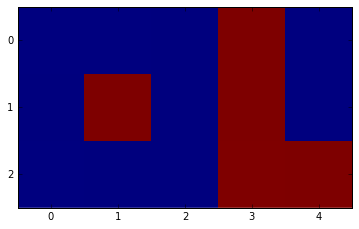

In [3]:
model = IsingModel(3, 5, 1.0, 0.0)
model.plot_lattice()

In [4]:
model.calculate_energy_of_spin(2, 0)

-2.0

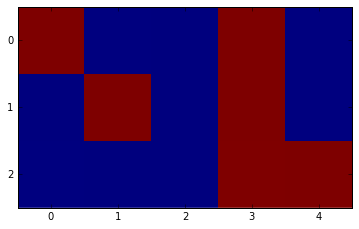

In [5]:
model.flip_spin(0, 0)
model.plot_lattice()

# Autocorrelation functions to determine how many sweeps needed before samples become statistically independent

In [6]:
def autocorrelation_k_steps(data, k):
    """
    Calculate autocorrelation of data after k steps
    https://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    mu = np.mean(data)  # mean
    n = np.size(data)  # number of data points
    variance = np.var(data)  # variance
    
    corr = 0.0  # autocorrelation
    for t in range(n - k):
        corr += (data[t] - mu) * (data[t + k] - mu)
    return corr / (variance * (n - k))

def plot_autocorrelation(data, kmax):
    """
    Plot autocorrelation function of data up to kmax steps
    """
    corr = np.zeros((kmax, ))
    for k in range(kmax):
        corr[k] = autocorrelation_k_steps(data, k)
        
    fig = plt.figure()
    
    plt.xlabel("Monte Carlo cycle")
    plt.ylabel("Autocorrelation")
    
    plt.ylim([0, 1])
    
    plt.plot(np.arange(kmax), corr, marker='s')
    
    plt.show()

# Function to sweep the lattice in a Monte Carlo simulation

Our function `sweep_lattice` will perform $NM$ Monte Carlo spin flip trials. We call it `sweep_lattice` because, on average, each spin will be selected for a Monte Carlo trial once during a 'sweep'.

In [7]:
def sweep_lattice(isingmodel, kT):
    """
    Perform N*M Monte Carlo spin flip attempts
    
    parameters:
        isingModel: Ising lattice model object instance
        kT: Boltzmann constant times temperature, $kT$
    returns:
        fraction of Monte Carlo proposals accepted
    """
    num_flips = isingmodel.M * isingmodel.N
    # keep track of number of Monte Carlo propsoals that are accepted
    n_accepted = 0
    
    for flip in range(num_flips):
        # choose a spin to flip at random
        i = np.random.randint(0, high=isingmodel.M)
        j = np.random.randint(0, high=isingmodel.N)
        
        # calculate old energy
        E_old = isingmodel.calculate_energy_of_spin(i, j)
        
        # flip the spin
        isingmodel.flip_spin(i, j)
        
        # calculate new energy
        E_new = isingmodel.calculate_energy_of_spin(i, j)
        
        # Monte Carlo: accept this proposal with probability e^{-\beta \Delta E}
        if np.random.uniform(0, 1) > np.exp(-(E_new - E_old) / kT):
            # reject move, flip spin back to original state
            isingmodel.flip_spin(i, j)
        else:
            # else: accept, do nothing
            n_accepted += 1
    return 1.0 * n_accepted / (model.M * model.N)  # return fraction of MC moves accepted

# Function for Monte Carlo simulations of Ising Model in Canonical Ensemble

In [8]:
def simulate(isingmodel, kT, num_sweeps, num_burn_sweeps, sample_frequency):
    """
    Monte Carlo simulations of Ising model in Canonical ensemble
    
    parameters:
        isingModel: Ising lattice model object instance
        kT: Boltzmann constant times temperature, $kT$
        num_sweeps: total number of Monte Carlo sweeps to perform in the simulation
        num_burn_sweeps: number of sweeps for equilibration (no samples taken during this period)
        sample_frequency: frequency at which to take samples
    """  
    t0 = time.time()  # keep track of timing
    
    # Print info
    print("Simulating Ising model:")
    isingmodel.print_params()
    print("\tTemperature (kT) = %f" % kT)
    print("\t%d total sweeps, %d of them burn sweeps" % (
            num_sweeps, num_burn_sweeps))
    print("\t\tSampling every %d sweeps" % sample_frequency)
    
    # store energy and net magnetization samples here
    energy_samples = np.zeros(((num_sweeps - num_burn_sweeps) / sample_frequency, ))
    magnetization_samples = np.zeros(((num_sweeps - num_burn_sweeps) / sample_frequency, ))
    
    # keep track of number of samples taken
    n_samples = 0
    # keep track of fraction of proposals accepted
    fraction_accepted_during_burn_sweeps = 0
    fraction_accepted_during_sampling_sweeps = 0

    for sweep in range(num_sweeps):
        # sweep lattice
        fraction_accepted = sweep_lattice(model, kT)

        # if burn sweeps are done, take samples
        if sweep >= num_burn_sweeps:
            fraction_accepted_during_sampling_sweeps += fraction_accepted
            
            # take a sample every sample_frequency sweeps
            if ((sweep - num_burn_sweeps) % sample_frequency) == 0:
                energy_samples[n_samples] = model.calculate_lattice_energy_per_spin()
                
                magnetization_samples[n_samples] = model.calculate_net_magnetization_per_spin()
                
                n_samples += 1
        else:
            # if still in burn regime, keep track of fraction accepted
            fraction_accepted_during_burn_sweeps += fraction_accepted
        
    print("\t\tFraction proposals accepted during burn sweeps = %f" % (
        1.0 * fraction_accepted_during_burn_sweeps / num_burn_sweeps))
    print("\t\tFraction proposals accepted during sampling regime = %f" % (
        1.0 * fraction_accepted_during_sampling_sweeps / (num_sweeps - num_burn_sweeps)))
    
    print("\t<E> = %f +/- %f" % (np.mean(energy_samples),
                                 1.96 * np.std(energy_samples) / np.sqrt(n_samples)))
    print("\t<m> = %f +/- %f" % (np.mean(magnetization_samples), 
                                 1.96 * np.std(magnetization_samples) / np.sqrt(n_samples)))
    
    print("\tSimulation finished. Took %s sec." % (time.time() - t0))
    assert((num_sweeps - num_burn_sweeps) / sample_frequency)
    
    return energy_samples, magnetization_samples

# An example Monte Carlo simulation of the Ising Model

In [9]:
model = IsingModel(20, 20, 1.0, 0.10)
critical_kT = model.critical_kT()

Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.100000
	Temperature (kT) = 2.382645
	2000 total sweeps, 1000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during burn sweeps = 0.166808
		Fraction proposals accepted during sampling regime = 0.172552
	<E> = -1.561524 +/- 0.007723
	<m> = 0.785645 +/- 0.004830
	Simulation finished. Took 4.49448895454 sec.


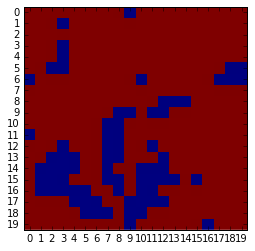

In [10]:
energy_samples, magnetization_samples = simulate(model, model.critical_kT() * 1.05, 2000, 1000, 1)
model.plot_lattice()

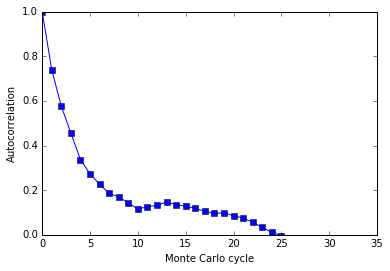

In [11]:
plot_autocorrelation(energy_samples, 35)

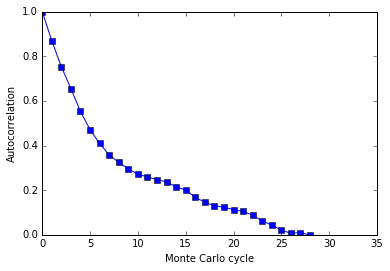

In [12]:
plot_autocorrelation(magnetization_samples, 35)

# Complete elliptic integrals of the first and second kind

From the Scipy website, note that these differ from the definition in Koonin and Meredith.

http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ellipk.html#scipy.special.ellipk
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ellipe.html#scipy.special.ellipe

`ellipk(kappa**2)`
returns $K_1(\kappa)$

`ellipe(kappa**2)`
returns $E_1(\kappa)$

In [13]:
from scipy.special import ellipk, ellipe

In [14]:
ellipk(0.2)

1.6596235986105281

In [15]:
ellipe(0.2)

1.4890350580958529

# Problem 8.6

$J=0$

If $J=0$, $E(s)=-h\sum s_i$.

Now, each spin is independent of the configuration of the others. So we can write the single-particle partition function $q$ as:

$q=e^{-\beta h} + e^{\beta h}=2 \cosh(\beta h)$

The partition function for the entire lattice, $Q$, is the product of these single-particle partition functions:

$Q=q^N,$ where $N$ is the total number of lattice sites.

i.e. $Q=(2\cosh(\beta h))^N$

From this partition function $Q$, we can calculate average thermodynamic quantities:

$\langle E \rangle =- \frac{\partial \log Q}{\partial \beta}$

$\langle m \rangle = \frac{\partial \log Q}{\partial \beta h}$

and then the magenetic susceptibility $\Xi$ and heat capacity $c_v$, defined as:

$ \chi = \frac{\partial \langle m \rangle}{\partial h}$

$ c_v  = \frac{\partial \langle E \rangle}{\partial T}$

With some calculus:

$\langle E \rangle = -N h \tanh(\beta h)$

$\langle m \rangle = h \tanh(\beta h)$

$\chi = \beta (\langle m^2 \rangle - \langle m \rangle^2)= \beta (1-\tanh^2(\beta h)) / N_{sites}$

$c_v/k = \beta^2 (\langle e^2 \rangle - \langle e \rangle^2)= (\beta h) ^2 (1-\tanh^2(\beta h)) / N_{sites}$

Let's try different $h$'s and simulate the Ising model to compare to this analytical formula. The `linspace` function in numpy will generate a span of $h$'s.

In [16]:
kT = 1.0
# array of h's to loop over
h = np.linspace(0.0, 3.0, 5)
# pre-allocate arrays to store thermodyanmic quantities
E = np.zeros((np.size(h), ))
m = np.zeros((np.size(h), ))
cv_ovr_k = np.zeros((np.size(h), ))
chi = np.zeros((np.size(h), ))

for i in range(np.size(h)):
    model = IsingModel(20, 20, 0.0, h[i])
    energy_samples, magnetization_samples = simulate(model, kT, 3000, 2000, 4)
    
    # record <E>, <m> at h[i]
    E[i] = np.mean(energy_samples)
    m[i] = np.mean(magnetization_samples)
    # related to fluctuations. multiply by M * N for cv of SYSTEM
    cv_ovr_k[i] = (np.mean(energy_samples ** 2) - np.mean(energy_samples) ** 2) / (kT ** 2)
    chi[i] = (np.mean(magnetization_samples ** 2) - np.mean(magnetization_samples) ** 2) / kT

Simulating Ising model:
	20 by 20 lattice
	J = 0.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 1.000000
	3000 total sweeps, 2000 of them burn sweeps
		Sampling every 4 sweeps
		Fraction proposals accepted during burn sweeps = 1.000000
		Fraction proposals accepted during sampling regime = 1.000000
	<E> = 0.000000 +/- 0.000000
	<m> = -0.004880 +/- 0.006155
	Simulation finished. Took 9.93126893044 sec.
Simulating Ising model:
	20 by 20 lattice
	J = 0.000000   (+ve means preferable )
	h = 0.750000
	Temperature (kT) = 1.000000
	3000 total sweeps, 2000 of them burn sweeps
		Sampling every 4 sweeps
		Fraction proposals accepted during burn sweeps = 0.364840
		Fraction proposals accepted during sampling regime = 0.365087
	<E> = -0.477810 +/- 0.003528
	<m> = 0.637080 +/- 0.004704
	Simulation finished. Took 10.8095188141 sec.
Simulating Ising model:
	20 by 20 lattice
	J = 0.000000   (+ve means preferable )
	h = 1.500000
	Temperature (kT) = 1.000000
	3000 total sweeps, 2000 

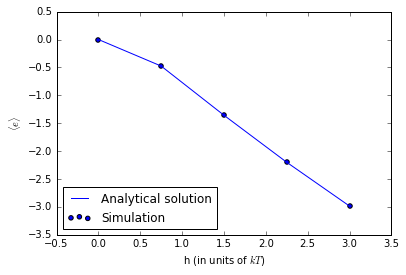

In [17]:
# plot results, compare to analytical model
plt.figure()
plt.scatter(h, E, label='Simulation')  # plot simulated data
plt.plot(h, -h * np.tanh(h / kT), label='Analytical solution')  # plot analytical sol'n
plt.xlabel("h (in units of $kT$)")
plt.ylabel(r"$\langle e \rangle$")
plt.legend(loc='lower left')
plt.show()

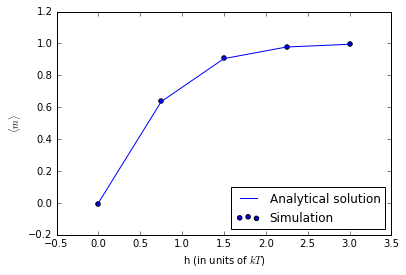

In [18]:
# plot results, compare to analytical model
plt.figure()
plt.scatter(h, m, label='Simulation')  # plot simulated data
plt.plot(h, np.tanh(h / kT), label='Analytical solution')  # plot analytical sol'n
plt.xlabel("h (in units of $kT$)")
plt.ylabel(r"$\langle m \rangle$")
plt.legend(loc='lower right')
plt.show()

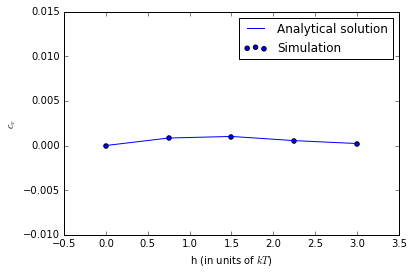

In [19]:
# plot results, compare to analytical model
plt.figure()
plt.scatter(h, cv_ovr_k, label='Simulation')  # plot simulated data
plt.plot(h, (h / kT) ** 2 * (1.0 - np.tanh(h / kT) ** 2) / (model.M * model.N), label='Analytical solution')  # plot analytical sol'n
plt.xlabel("h (in units of $kT$)")
plt.ylabel(r"$c_v$")
plt.legend(loc='upper right')
plt.show()

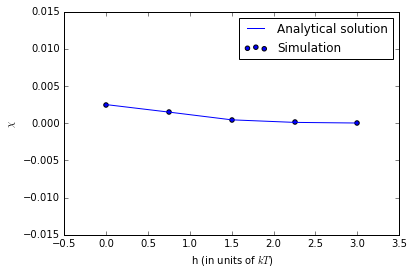

In [20]:
# plot results, compare to analytical model
plt.figure()
plt.scatter(h, chi, label='Simulation')  # plot simulated data
plt.plot(h, (1.0 - np.tanh(h / kT) ** 2) / kT / (model.M * model.N), label='Analytical solution')  # plot analytical sol'n
plt.xlabel("h (in units of $kT$)")
plt.ylabel(r"$\chi$")
plt.legend(loc='upper right')
plt.show()

# Exercise 8.7 and 8.9 together

Plot analytical solution to Ising Model in the limit of an infinitely large lattice

In [21]:
def exact_soln(model, kT):
    """
    Return average energy
    
    Parameters:
        model: an instance of the IsingModel class.
        kT: temperature ($k_b T$)
    returns dictionary of exact values
        e.g:
            soln = exact_soln(model, kt)
            soln['cv']
        returns cv.
    """  
    num_sites = model.M * model.N
    J_theirs = model.J / kT
    K = 2.0 * np.sinh(2.0 * J_theirs) / np.cosh(2.0 * J_theirs) ** 2
    K1 = ellipk(K ** 2)
    K_prime = 2.0 * np.tanh(2.0 * J_theirs) ** 2 - 1.0
    E1 = ellipe(K ** 2)
    
    z = np.exp(-2.0 * J_theirs)
    
    avg_E = -J_theirs / np.tanh(2.0 * J_theirs) * (1.0 + 2.0 / np.pi * K_prime * K1)
    cv = 2.0 / np.pi * (J_theirs / np.tanh(2.0 * J_theirs)) ** 2 *\
        (2.0 * K1 - 2.0 * E1 - (1.0 - K_prime) * (np.pi/2.0 + K_prime * K1))
    avg_m = (1.0 + z**2)**0.25 * (1.0 - 6.0 * z ** 2 + z ** 4) ** (1.0/8.0) / np.sqrt(1.0-z**2)
    
    return {'m': avg_m, 'cv': cv, 'e': avg_E}

Example of how this function works:

In [22]:
model = IsingModel(20, 20, 1.0, 0.0)
model.print_params()
soln = exact_soln(model, 2.2)
soln

	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000


{'cv': 1.4142776913433117, 'e': -0.7029496109538429, 'm': 0.78475513138392128}

In [23]:
soln['e']

-0.7029496109538429

### Explore parameter space; compare simulation to analytical model

When $h=0$, an Ising model simulation is characterized by $M$, $N$, and $J/k_B T$. Equivalently, we can fix $kT$ and vary $J$.

In [24]:
kT = 1.0
J = np.linspace(0.01, 0.8)

Store analytical solution in these pre-allocated arrays.

In [25]:
cvs = np.zeros((np.size(J), ))
avg_es = np.zeros((np.size(J), ))
avg_ms = np.zeros((np.size(J), ))

Store simulated solutions here

In [26]:
cvs_sim = np.zeros((np.size(J), ))
avg_es_sim = np.zeros((np.size(J), ))
avg_ms_sim = np.zeros((np.size(J), ))

In [27]:
for i in range(np.size(J)):
    # construct model with this J.
    model = IsingModel(24, 24, J[i], 0.0)
    
    # get and store analytical sol'n
    soln = exact_soln(model, kT)
    
    cvs[i] = soln['cv']
    avg_es[i] = soln['e']
    avg_ms[i] = soln['m']
    
    # Simulate, record results
    energy_samples, magnetization_samples = simulate(model, kT, 7000, 3000, 10)
    
    avg_es_sim[i] = np.mean(energy_samples)
    avg_ms_sim[i] = np.mean(magnetization_samples)
    cvs_sim[i] = (np.mean(energy_samples ** 2) - np.mean(energy_samples) ** 2) / (
        kT ** 2) * model.M * model.N

Simulating Ising model:
	24 by 24 lattice
	J = 0.010000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 1.000000
	7000 total sweeps, 3000 of them burn sweeps
		Sampling every 10 sweeps
		Fraction proposals accepted during burn sweeps = 0.985082
		Fraction proposals accepted during sampling regime = 0.985048
	<E> = -0.000183 +/- 0.000058
	<m> = 0.000295 +/- 0.004264
	Simulation finished. Took 26.8854730129 sec.
Simulating Ising model:
	24 by 24 lattice
	J = 0.026122   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 1.000000
	7000 total sweeps, 3000 of them burn sweeps
		Sampling every 10 sweeps
		Fraction proposals accepted during burn sweeps = 0.960974
		Fraction proposals accepted during sampling regime = 0.960618
	<E> = -0.001381 +/- 0.000149
	<m> = -0.002109 +/- 0.004178
	Simulation finished. Took 26.0055580139 sec.
Simulating Ising model:
	24 by 24 lattice
	J = 0.042245   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 1.000000
	7000 total sweeps, 30

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in double_scalars


Plot results. Points: simulation, Lines: analytical soln

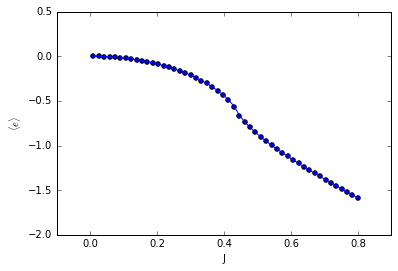

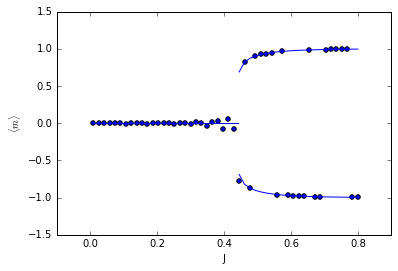

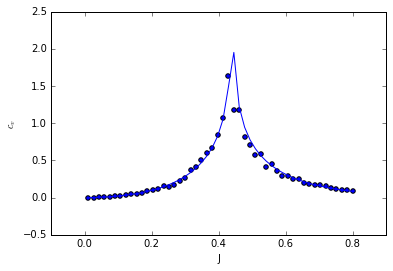

In [29]:
critical_J = kT * np.log(1.0 + np.sqrt(2.0))/2.0

plt.figure()
plt.plot(J, avg_es)
plt.scatter(J, avg_es_sim)
plt.xlabel('J')
plt.ylabel(r'$\langle e \rangle$')
plt.savefig('avgE.png', format='png', dpi=200)
plt.show()

plt.figure()
plt.plot(J, avg_ms, color='b')
plt.plot(J, -avg_ms, color='b')
plt.plot([np.min(J), critical_J], [0.0, 0.0], color='b')
plt.scatter(J, avg_ms_sim)
plt.xlabel('J')
plt.ylabel(r'$\langle m \rangle$')
plt.show()

plt.figure()
plt.plot(J, cvs)
plt.scatter(J, cvs_sim)
plt.xlabel('J')
plt.ylabel(r'$c_v$')
plt.show()